# Next Generation Reservoir Computing (NG-RC)

This notebook demonstrates the Next Generation Reservoir Computing (NG-RC) framework applied to the Lorenz 63 system.

The implementation follows the methodology introduced by:

Daniel J. Gauthier, Erik Bollt, Aaron D. Griffith,  
Wendson A. S. Barbosa.

## Modeling the Lorenz 63 Chaotic Attractor

### Objective

- Learn the dynamics of the **Lorenz 63** system from data  
- Train a **Nonlinear Vector AutoRegression (NVAR)** model and use it to make autonomous predictions  
- Evaluate short term prediction accuracy and long term behavior  


### Procedure

- Generate Lorenz 63 time series data using numerical integration  
- Construct NVAR features from delayed states and nonlinear terms  
- Train the model using linear regression  
- Perform autonomous prediction on unseen data  
- Evaluate prediction accuracy and dynamical behavior  

In [1]:
# Source: LorenzConstLinQuadraticNVARtimedelay-RK23.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## 1. Simulation Setup

All time quantities are expressed in Lorenz time units.

| Symbol | Value | Description |
|--------|--------|-------------|
| $dt$ | 0.025 | Time step size, $t_{n+1} = t_n + dt$ |
| $T_{\text{warmup}}$ | 5.0 | Transient period (discarded) |
| $T_{\text{train}}$ | 10.0 | Training duration |
| $T_{\text{test}}$ | 120.0 | Prediction duration |
| $T_{\text{total}}$ | 135.0 | Total simulation time, $T_{\text{warmup}} + T_{\text{train}} + T_{\text{test}}$ |
| $T_{\text{plot}}$ | 20.0 | Portion of prediction interval shown |
| $T_{\lambda}$ | 1.104 | Lyapunov time |


In [1]:
## Parameters

# Time step of numerical integration
dt = 0.025

# Warm-up time (no training; allows transients to decay)
warmup = 5.0

# Training duration (used to learn output weights)
traintime = 10.0

# Testing duration (model prediction phase)
testtime = 120.0

# Total simulation time
maxtime = warmup + traintime + testtime

# Portion of test duration shown in plots
plottime = 20.0

# Lyapunov time of the Lorenz system (predictability scale)
lyaptime = 1.104


### 1.1 Discrete Time Parameters

Time is discretized using a fixed step size $dt$.  
Each continuous time interval is converted into a number of discrete samples by dividing by $dt$.

| Name | Symbol | Definition | Value |
|------|--------|------------|--------|
| Warmup samples | $N_{\text{warmup}}$ | $T_{\text{warmup}} / dt$ | 200 |
| Training samples | $N_{\text{train}}$ | $T_{\text{train}} / dt$ | 400 |
| Warmup + Training samples | $N_{\text{warm+train}}$ | $N_{\text{warmup}} + N_{\text{train}}$ | 600 |
| Testing samples | $N_{\text{test}}$ | $T_{\text{test}} / dt$ | 4800 |
| Total samples | $N_{\text{total}}$ | $T_{\text{total}} / dt$ | 5400 |
| Plot samples | $N_{\text{plot}}$ | $T_{\text{plot}} / dt$ | 800 |
| Samples per Lyapunov time | $N_{\lambda}$ | $T_{\lambda} / dt$ | 44 |


In [3]:
# Convert time durations to discrete sample counts

warmup_pts    = round(warmup / dt)        # Number of warm-up samples
traintime_pts = round(traintime / dt)     # Number of training samples
warmtrain_pts = warmup_pts + traintime_pts  # Samples before prediction
testtime_pts  = round(testtime / dt)      # Number of testing samples
maxtime_pts   = round(maxtime / dt)       # Total number of samples
plottime_pts  = round(plottime / dt)      # Samples shown in plots
lyaptime_pts  = round(lyaptime / dt)      # Lyapunov time in samples

# Display computed sample counts
print("warmup_pts    =", warmup_pts)
print("traintime_pts =", traintime_pts)
print("warmtrain_pts =", warmtrain_pts)
print("testtime_pts  =", testtime_pts)
print("maxtime_pts   =", maxtime_pts)
print("plottime_pts  =", plottime_pts)
print("lyaptime_pts  =", lyaptime_pts)

warmup_pts    = 200
traintime_pts = 400
warmtrain_pts = 600
testtime_pts  = 4800
maxtime_pts   = 5400
plottime_pts  = 800
lyaptime_pts  = 44


### 1.2 NVAR Feature Parameters
The following parameters define the dimensional structure of the NVAR feature space constructed from delayed Lorenz states.


| Name | Symbol | Definition | Value |
|------|--------|------------|--------|
| Input dimension | $d$ | Number of state variables $(x, y, z)$ | 3 |
| Number of delay taps | $k$ | Number of time delay copies | 2 |
| Linear feature dimension | $d_{\text{lin}}$ | $k \cdot d$ | 6 |
| Quadratic feature dimension | $d_{\text{nonlin}}$ | $\dfrac{d_{\text{lin}}(d_{\text{lin}} + 1)}{2}$ | 21 |
| Total feature dimension | $d_{\text{tot}}$ | $1 + d_{\text{lin}} + d_{\text{nonlin}}$ | 28 |


In [4]:
# NVAR feature parameters

d = 3                 # Input dimension (x, y, z)
k = 2                 # Number of time-delay taps

dlin = k * d          # Linear feature dimension
dnonlin = int(dlin * (dlin + 1) / 2)  # Quadratic feature dimension

dtot = 1 + dlin + dnonlin  # Total feature dimension (constant + linear + quadratic)

# Display feature dimensions
print("d       =", d)
print("k       =", k)
print("dlin    =", dlin)
print("dnonlin =", dnonlin)
print("dtot    =", dtot)

d       = 3
k       = 2
dlin    = 6
dnonlin = 21
dtot    = 28


### 1.3 Regression and Time Grid

The following parameters define the regression regularization and the discrete evaluation time grid.

| Name | Symbol | Definition |
|------|--------|------------|
| Ridge regularization parameter | $\alpha$ | Controls the strength of regularization |
| Evaluation time grid | $t_{\text{eval}}$ | $t_{\text{eval}} \in [0, T_{\text{total}}]$ with $N_{\text{total}} + 1$ discrete points |


In [5]:
# Ridge regression parameter (regularization strength)
ridge_param = 2.5e-6

# Time grid for full simulation interval
# (maxtime_pts + 1 ensures spacing of dt)
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)
print("First 5 time points:", t_eval[:5])
print("Last 5 time points :", t_eval[-5:])

First 5 time points: [0.    0.025 0.05  0.075 0.1  ]
Last 5 time points : [134.9   134.925 134.95  134.975 135.   ]


---
## 2. Lorenz63 System

The Lorenz63 system is a three-dimensional nonlinear system that exhibits chaotic behavior.

$$
\begin{aligned}
\dot{x}(t) &= \sigma \big(y(t) - x(t)\big) \\
\dot{y}(t) &= x(t)\big(\rho - z(t)\big) - y(t) \\
\dot{z}(t) &= x(t)y(t) - \beta z(t)
\end{aligned}
$$

**Parameters**
$$
(\sigma, \rho, \beta) = \left(10, 28, \frac{8}{3}\right)
$$

These parameter values produce chaotic dynamics.


In [6]:
# Lorenz–63 parameters
sigma = 10
beta = 8 / 3
rho = 28

# Lorenz system definition
def lorenz(t, y):
    """
    Computes time derivatives for the Lorenz-63 system.
    
    Parameters:
        t : float
            Current time (required by solve_ivp)
        y : array-like
            State vector [x, y, z]
            
    Returns:
        list
            Time derivatives [dx/dt, dy/dt, dz/dt]
    """
    
    dx = sigma * (y[1] - y[0])
    dy = y[0] * (rho - y[2]) - y[1]
    dz = y[0] * y[1] - beta * y[2]
    
    return [dx, dy, dz]


### 2.1 Generating Training Data from the Lorenz 63 System

The Lorenz 63 system is numerically integrated over the interval 
$[0, T_{\text{total}}]$ using a uniform time step $dt$.

$$
t_n = n\,dt, \quad n = 0, 1, \dots, N_{\text{total}}
$$

where $N_{\text{total}}$ is the total number of time steps.  
For simplicity, we define $ N := N_{\text{total}}, $ and use $N$ throughout the remainder of this section.

**Initial condition**

$$
(x(0), y(0), z(0)) = (17.6772,\; 12.9314,\; 43.9140)
$$

At each time step, the system state is

$$
\mathbf{x}(t_n) =
\begin{bmatrix}
x(t_n) \\
y(t_n) \\
z(t_n)
\end{bmatrix}
$$

This produces the time series data used for training and testing.

In [7]:
# Integrate the Lorenz system to generate time-series data
# Initial condition lies on the attractor to ensure typical chaotic dynamics

lorenz_soln = solve_ivp(
    lorenz,                         # Lorenz system function
    (0, maxtime),                   # Time interval
    [17.67715816276679,
     12.931379185960404,
     43.91404334248268],            # Initial state [x0, y0, z0]
    t_eval=t_eval,                  # Discrete evaluation times
    method='RK23'                   # Runge–Kutta method
)

print("Solution status:", lorenz_soln.message)
print("State array shape:", lorenz_soln.y.shape)

Solution status: The solver successfully reached the end of the integration interval.
State array shape: (3, 5401)


After numerical integration, the full trajectory is collected into the data matrix

$$
\mathbf{X}_{\text{total}}
=
\begin{bmatrix}
x(t_0) & x(t_1) & \cdots & x(t_{N}) \\
y(t_0) & y(t_1) & \cdots & y(t_{N}) \\
z(t_0) & z(t_1) & \cdots & z(t_{N})
\end{bmatrix}
\in \mathbb{R}^{3 \times (N + 1)}.
$$

### 2.2 Total Variance

The total variance is computed over all state variables 
($x$, $y$, and $z$) across the entire time series:

$$
\mathrm{Var}_{\text{total}}
=
\mathrm{Var}\big( x(t_n),\, y(t_n),\, z(t_n) \big)_{n=0}^{N}
$$

This quantity is used to normalize the prediction error.

The initial condition is chosen on the Lorenz attractor to ensure representative chaotic dynamics.



In [8]:
# Compute total variance across all state variables (x, y, z)
# Used later to normalize prediction error
total_var = np.var(lorenz_soln.y[0:d, :])

print("Total variance =", total_var)

Total variance = 205.3589867325693


---
## 3. NVAR Feature Construction

At each time step $t$, the NVAR feature vector is constructed as

$$
\mathbf{O}_{\text{tot}}(t_n) =
\begin{bmatrix}
\text{Bias} \\
\text{Linear + Delay Terms} \\
\text{Nonlinear Terms}
\end{bmatrix}.
$$

- The **bias term** is a constant equal to 1.
- The **linear features** $\mathbf{O}_{\text{lin}}(t)$ include the current state variables and their delayed versions.
- The **nonlinear features** $\mathbf{O}_{\text{nonlin}}(t)$ consist of polynomial combinations (products) of the linear features.

The complete feature vector is formed by stacking the bias, linear, and nonlinear terms together.  
This combined feature vector is then used to train the NVAR model.

### 3.1 Linear and Delay Features

The linear feature vector at time $t$ consists of the current state 
variables and their delayed versions:

$$
\mathbf{O}_{\text{lin}}(t_n)
=
\begin{bmatrix}
x(t_n) \\
y(t_n) \\
z(t_n) \\
x(t_{n-1}) \\
y(t_{n-1}) \\
z(t_{n-1})
\end{bmatrix}.
$$

The delay $\tau$ corresponds to one discrete time step, i.e., $\tau = dt$.

Here, $d = 3$ represents the number of state variables 
($x$, $y$, $z$), and we use one delay in addition to the current state.

Therefore, the total number of linear features is

$$
d_{\text{lin}} = d \times 2 = 6.
$$

In [9]:
# Construct linear (delay) feature matrix

# Array to store linear delay features
# Shape: (dlin, total_time_steps)
x = np.zeros((dlin, maxtime_pts))

# Fill delay features using Lorenz time series
for delay in range(k):
    for j in range(delay, maxtime_pts):
        x[d*delay:d*(delay+1), j] = lorenz_soln.y[:, j - delay]

print("Linear feature matrix shape:", x.shape)

Linear feature matrix shape: (6, 5400)


### 3.2 Construction of the Delay Embedded Data Matrix

Using a one-step delay ($\tau = dt$), we construct the full delay embedded data matrix by stacking the linear features across all time steps:

$$
\mathbf{X}_{\text{total}}
=
\begin{bmatrix}
x(t_1) & x(t_2) & \cdots & x(t_N) \\
y(t_1) & y(t_2) & \cdots & y(t_N) \\
z(t_1) & z(t_2) & \cdots & z(t_N) \\
x(t_0) & x(t_1) & \cdots & x(t_{N-1}) \\
y(t_0) & y(t_1) & \cdots & y(t_{N-1}) \\
z(t_0) & z(t_1) & \cdots & z(t_{N-1})
\end{bmatrix}
\in \mathbb{R}^{6 \times N}.
$$

The matrix is then partitioned sequentially along the time axis:

$$
\mathbf{X}_{\text{total}}
=
\big[
\underbrace{\mathbf{X}_{\text{warmup}}}_{200\ \text{columns}}
\;\big|\;
\underbrace{\mathbf{X}_{\text{train}}}_{400\ \text{columns}}
\;\big|\;
\underbrace{\mathbf{X}_{\text{test}}}_{4800\ \text{columns}}
\big].
$$

### 3.3 Building the Training Feature Matrix

After discarding the warmup samples, we construct the NVAR feature matrix 
using only the training portion of the data.

For each training time step, the complete feature vector has the form

$$
\mathbf{O}_{\text{tot}}(t_n) =
\begin{bmatrix}
1 \\
\mathbf{O}_{\text{lin}}(t_n) \\
\ {\text{Nonlinear Terms}}
\end{bmatrix}.
$$

- The first row is the constant bias term.
- The next rows contain the linear (current + delayed) features.
- The nonlinear features will be constructed in the next step.

In [10]:
# Construct training feature matrix (constant + linear)

# Initialize with ones (first row = bias term)
out_train = np.ones((dtot, traintime_pts))

# Insert linear features (excluding warm-up region)
out_train[1:dlin+1, :] = x[:, warmup_pts-1:warmtrain_pts-1]

print("Training feature matrix shape:", out_train[1:dlin+1, :].shape)

Training feature matrix shape: (6, 400)


At this stage (before adding nonlinear terms), 
the training feature matrix contains only the bias and linear features 
from time indices 200 to 599:

$$
\mathbf{O}_{\text{train}}
=
\begin{bmatrix}
1 & 1 & \cdots & 1 \\
x(t_{200}) & x(t_{201}) & \cdots & x(t_{599}) \\
y(t_{200}) & y(t_{201}) & \cdots & y(t_{599}) \\
z(t_{200}) & z(t_{201}) & \cdots & z(t_{599}) \\
x(t_{199}) & x(t_{200}) & \cdots & x(t_{598}) \\
y(t_{199}) & y(t_{200}) & \cdots & y(t_{598}) \\
z(t_{199}) & z(t_{200}) & \cdots & z(t_{598})
\end{bmatrix}
\in \mathbb{R}^{7 \times 400}.
$$

### 3.4 Nonlinear Feature Expansion

To capture nonlinear dynamics, we extend the feature vector by adding 
quadratic polynomial terms constructed from the linear features.

These include:

- Squared terms, such as $x(t)^2$, $y(t)^2$, $x(t-\tau)^2$.
- Interaction terms, such as $x(t)y(t)$ and $x(t)x(t-\tau)$.

With 6 linear features, all second order polynomial combinations 
(including squares) produce 21 quadratic terms.

The nonlinear feature vector is therefore


$$
\mathbf{O}_{\text{nonlin}}(t_n)
=
\begin{bmatrix}
x(t_n)^2 \\
y(t_n)^2 \\
z(t_n)^2 \\
x(t_n)y(t_n) \\
\vdots \\
z(t_n)z(t_{n-1}) \\
x(t_{n-1})^2 \\
y(t_{n-1})^2 \\
z(t_{n-1})^2
\end{bmatrix}.
$$

In [11]:
# Construct nonlinear (quadratic) features for training

cnt = 0  # Counter to track quadratic feature index

for i in range(dlin):
    for j in range(i, dlin):
        # Multiply linear features to form quadratic terms
        out_train[dlin + 1 + cnt, :] = (
            x[i, warmup_pts-1:warmtrain_pts-1] *
            x[j, warmup_pts-1:warmtrain_pts-1]
        )
        cnt += 1

print("Nonlinear features added:", cnt)
print("Final training matrix shape:", out_train.shape)


Nonlinear features added: 21
Final training matrix shape: (28, 400)


### 3.5 Final NVAR Training Feature Matrix

The NVAR training feature matrix is constructed by stacking:

- a constant bias term,
- the linear delay features,
- and the nonlinear (quadratic) features.

For each training time step, the complete observable vector is

$$
\mathbf{O}_{\text{tot}}(t_n) =
\begin{bmatrix}
1 \\
\mathbf{O}_{\text{lin}}(t_n) \\
\mathbf{O}_{\text{nonlin}}(t_n)
\end{bmatrix},
\qquad
\mathbf{O}_{\text{tot}} \in \mathbb{R}^{28 \times 1}
$$

Here:

- 1 bias term,
- 6 linear (current + delayed) features,
- 21 quadratic features,

giving a total of

$$
1 + 6 + 21 = 28
$$

features per time step.

All second-order polynomial combinations of the six linear features are included.

For the training interval (time indices 200 to 599), stacking the observables gives

$$
\mathbf{O}_{\text{train}}
\in
\mathbb{R}^{28 \times 400}
=
\begin{bmatrix}
1 & 1 & \cdots & 1 \\
x(t_{200}) & x(t_{201}) & \cdots & x(t_{599}) \\
y(t_{200}) & y(t_{201}) & \cdots & y(t_{599}) \\
\vdots & \vdots & \ddots & \vdots \\
y(t_{200})z(t_{200}) & y(t_{201})z(t_{201}) & \cdots & y(t_{599})z(t_{599}) \\
z(t_{199})^2 & z(t_{200})^2 & \cdots & z(t_{598})^2 \\
z(t_{199})z(t_{200}) & z(t_{200})z(t_{201}) & \cdots & z(t_{598})z(t_{599})
\end{bmatrix}
$$

Each column corresponds to one training time step.

---


## 4. Training the Output Weights

Once the NVAR feature matrix is constructed, we compute the output weight 
matrix $W_{\text{out}}$ using ridge regression.

The model is trained to predict the state increment

$$
\Delta \mathbf{x}(t_n)
=
\mathbf{x}(t_{n+1}) - \mathbf{x}(t_{n}),
$$

rather than the state itself.

Stacking all training samples gives the matrix equation

$$
\Delta \mathbf{X}
=
W_{\text{out}} \, \mathbf{O}_{\text{train}},
$$

where

- $\mathbf{O}_{\text{train}} \in \mathbb{R}^{28 \times 400}$ is the NVAR feature matrix,
- $\Delta \mathbf{X} \in \mathbb{R}^{3 \times 400}$ contains the vectors 
  $\mathbf{x}(t_{n+1}) - \mathbf{x}(t_n)$ for $n=200,\dots,599$.
- $W_{\text{out}} \in \mathbb{R}^{3 \times 28}$ is the output weight matrix.

To compute $W_{\text{out}}$, we solve a regularized least-squares problem 
(ridge regression), which gives

$$
W_{\text{out}}
=
\Delta \mathbf{X}
\, \mathbf{O}_{\text{train}}^{T}
\left(
\mathbf{O}_{\text{train}} \mathbf{O}_{\text{train}}^{T}
+ \alpha I
\right)^{-1},
$$

where $\alpha$ is the regularization parameter.

Only $W_{\text{out}}$ is learned.  
The observable construction remains fixed.

In [12]:
# Construct training ta rget (state increment)
# Target = change in Lorenz state between consecutive time steps

Y = x[0:d, warmup_pts:warmtrain_pts] - \
    x[0:d, warmup_pts-1:warmtrain_pts-1]

print("Target matrix shape:", Y.shape)


# Ridge regression to compute output weights

W_out = (
    Y @ out_train.T @
    np.linalg.pinv(
        out_train @ out_train.T +
        ridge_param * np.identity(dtot)
    )
)

print("Output weight matrix shape:", W_out.shape)

Target matrix shape: (3, 400)
Output weight matrix shape: (3, 28)


## 5. Autonomous Prediction

After learning $W_{\text{out}}$, the model reconstructs the Lorenz trajectory
by predicting the state increment.

The model computes the predicted increment


$$
\Delta \hat{\mathbf{x}}(t_n)
=
W_{\text{out}} \, \mathbf{O}_{\text{tot}}(t_n),
$$

and the next state is obtained as

$$
\underbrace{\hat{\mathbf{x}}(t_{n+1})}_{3 \times 1}
=
\underbrace{\hat{\mathbf{x}}(t_n)}_{3 \times 1}
+
\underbrace{W_{\text{out}}}_{3 \times 28}
\underbrace{\mathbf{O}_{\text{tot}}(t_n)}_{28 \times 1}.
$$



during training, prediction is performed by adding the learned increment
to the current predicted state.

The predicted state is then fed back to construct

$$
\mathbf{O}_{\text{tot}}(t_{n+1}).
$$


In [13]:
# Predict training data using learned weights
# x(t+1) = x(t) + W_out Φ(t)

x_predict = (
    x[0:d, warmup_pts-1:warmtrain_pts-1] +
    W_out @ out_train[:, :traintime_pts]
)

print("Training prediction shape:", x_predict.shape)

Training prediction shape: (3, 400)


### 5.1 Training Error (NRMSE)

To evaluate prediction accuracy, we use the normalized root mean square error (NRMSE):

$$
\text{NRMSE}
=
\sqrt{
\frac{
\mathrm{mean}\!\left( \| \mathbf{x}(t_n) - \hat{\mathbf{x}}(t_n) \|^2 \right)
}{
\mathrm{Var}_{\text{total}}
}
}.
$$

Here:

- $\mathbf{x}(t_n)$ is the true state,
- $\hat{\mathbf{x}}(t_n)$ is the predicted state,
- $\mathrm{Var}_{\text{total}}$ is the total variance of the Lorenz trajectory.

NRMSE measures how large the prediction error is relative to the overall scale of the system.

In [14]:
# Training error (NRMSE)

# Difference between true Lorenz states and predicted states
error = x[0:d, warmup_pts:warmtrain_pts] - x_predict

# Normalized Root Mean Square Error
rms = np.sqrt(np.mean(error**2) / total_var)

print("Training NRMSE:", rms)


Training NRMSE: 0.0001024156159533598


## 6. Testing Phase Setup

For autonomous prediction:

- A feature vector container `out_test` is created to hold the NVAR features at each time step.
- A matrix `x_test` is allocated to store the predicted states.
- The first test state is initialized using the final state from the training phase.

From this initial condition, the model evolves iteratively in autonomous mode.

In [15]:
# Prepare storage for testing (prediction phase)

# Feature vector for one time step
out_test = np.zeros(dtot)

# Matrix to store predicted states during testing
x_test = np.zeros((dlin, testtime_pts))

# Initialize with final training state
x_test[:, 0] = x[:, warmtrain_pts - 1]

print("Testing state matrix shape:", x_test.shape)

Testing state matrix shape: (6, 4800)


### 6.1 Autonomous Prediction (Testing Phase)

During testing, the model runs recursively in autonomous mode.

At each time step:

- The current predicted state is used to construct the feature vector.
- Quadratic (nonlinear) features are computed.
- Delay taps are shifted forward.
- The next state is updated as

$$
\hat{\mathbf{x}}(t_{n+1})
=
\hat{\mathbf{x}}(t_n)
+
W_{\text{out}} \, \mathbf{O}_{\text{tot}}(t_n)
$$

The model uses its own previous prediction to generate the next state.

#### Test Error (NRMSE)

Prediction accuracy is evaluated over one Lyapunov time using

$$
\text{NRMSE}
=
\sqrt{
\frac{
\mathrm{mean}\!\left(
\| \mathbf{x}(t_n) - \hat{\mathbf{x}}(t_n) \|^2
\right)
}{
\mathrm{Var}_{\text{total}}
}
}
$$

This measures the prediction error relative to the overall variability of the system.

In [16]:
# Autonomous prediction (testing phase)

for j in range(testtime_pts - 1):

    # Insert linear features (current delayed state)
    out_test[1:dlin+1] = x_test[:, j]

    # Construct quadratic features
    cnt = 0
    for row in range(dlin):
        for column in range(row, dlin):
            out_test[dlin + 1 + cnt] = (
                x_test[row, j] * x_test[column, j]
            )
            cnt += 1

    # Shift delay taps for next time step
    x_test[d:dlin, j+1] = x_test[0:(dlin - d), j]

    # Predict next state (add learned increment)
    x_test[0:d, j+1] = (
        x_test[0:d, j] + W_out @ out_test
    )


# Compute NRMSE over one Lyapunov time
true_segment = x[0:d,
                 warmtrain_pts-1 : warmtrain_pts+lyaptime_pts-1]

pred_segment = x_test[0:d, 0:lyaptime_pts]

test_nrmse = np.sqrt(
    np.mean((true_segment - pred_segment)**2) / total_var
)

print("Test prediction shape:", x_test.shape)
print("Lyapunov window length:", lyaptime_pts)
print("Test NRMSE (1 Lyapunov time):", test_nrmse)

Test prediction shape: (6, 4800)
Lyapunov window length: 44
Test NRMSE (1 Lyapunov time): 0.0006579903202056402


## 7. Testing Results and Performance Analysis

We compare the NG-RC prediction with the true Lorenz trajectory to evaluate short term accuracy and long term behavior.

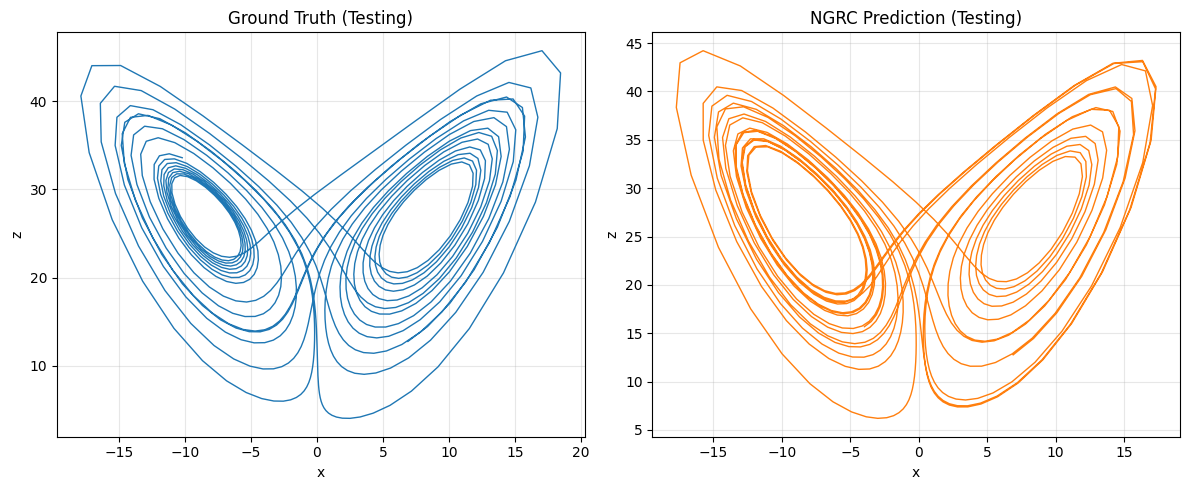

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Extract data (same alignment as animation/static error)
true_x = x[0, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
true_z = x[2, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]

pred_x = x_test[0, :plottime_pts]
pred_z = x_test[2, :plottime_pts]

#  Left: Ground Truth 
axs[0].plot(true_x, true_z,
            color='tab:blue',
            linewidth=1)

axs[0].set_title('Ground Truth (Testing)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].grid(alpha=0.3)

#  Right: Prediction 
axs[1].plot(pred_x, pred_z,
            color='tab:orange',
            linewidth=1)

axs[1].set_title('NGRC Prediction (Testing)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


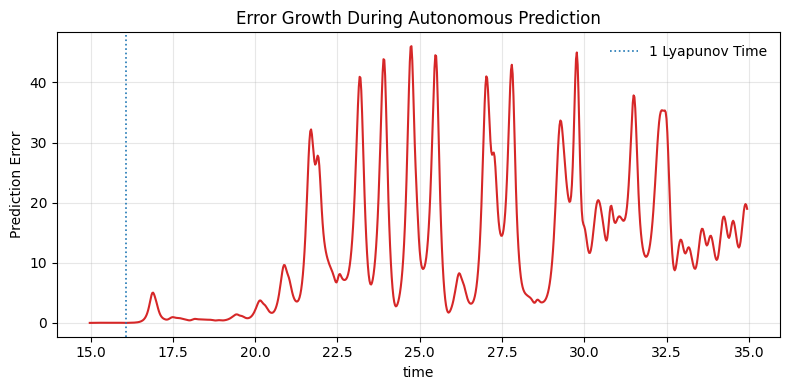

In [18]:
# Compute error magnitude (Euclidean norm at each time step)
true_slice = slice(warmtrain_pts - 1,
                   warmtrain_pts + plottime_pts - 1)

error = np.sqrt(
    np.sum(
        (x[0:3, true_slice] - x_test[0:3, :plottime_pts])**2,
        axis=0
    )
)

# Physical time axis
t_error = t_eval[true_slice]

# 1 Lyapunov time boundary
t_lyap = t_eval[warmtrain_pts - 1] + lyaptime_pts * (t_eval[1] - t_eval[0])

plt.figure(figsize=(8, 4))

plt.plot(t_error, error, linewidth=1.5,color='tab:red'
)

plt.axvline(t_lyap,
            linestyle=':',
            linewidth=1.2,
            label='1 Lyapunov Time')

plt.xlabel("time")
plt.ylabel("Prediction Error")
plt.title("Error Growth During Autonomous Prediction")
plt.grid(alpha=0.3)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


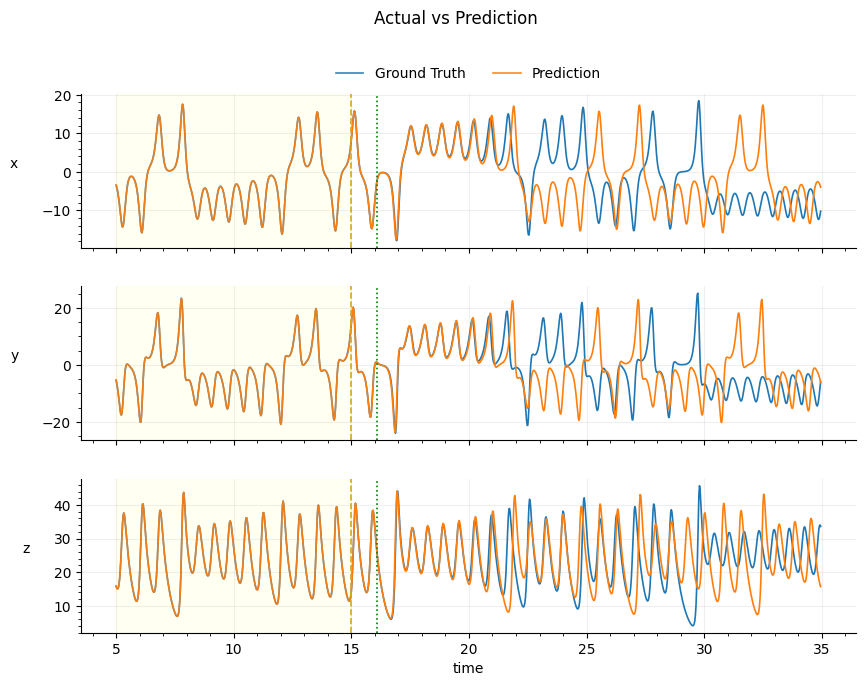

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

labels = ['x', 'y', 'z']

# Define slices clearly
train_slice = slice(warmup_pts, warmtrain_pts)
test_slice  = slice(warmtrain_pts - 1,
                    warmtrain_pts + plottime_pts - 1)

t_train = t_eval[train_slice]
t_test  = t_eval[test_slice]

t_boundary = t_eval[warmtrain_pts - 1]
dt_local = t_eval[1] - t_eval[0]
t_lyap = t_boundary + lyaptime_pts * dt_local

for i in range(3):

    # Training region shading
    axs[i].axvspan(t_train[0], t_boundary, color='yellow', alpha=0.05)

    # Training ground truth
    axs[i].plot(t_train,
                x[i, train_slice],
                color='tab:blue', linewidth=1.2, alpha=0.9,
                label='Ground Truth' if i == 0 else None)

    # Training prediction
    axs[i].plot(t_train,
                x_predict[i, :],
                color='tab:orange', linewidth=1.2, alpha=0.9,
                label='Prediction' if i == 0 else None)

    # Testing ground truth
    axs[i].plot(t_test, x[i, test_slice], color='tab:blue', linewidth=1.2)

    # Testing prediction
    axs[i].plot(t_test, x_test[i, :plottime_pts], color='tab:orange', linewidth=1.2)

    # Boundaries
    axs[i].axvline(t_boundary, linestyle='--', color='goldenrod', linewidth=1.2)

    axs[i].axvline(t_lyap, linestyle=':', color='green', linewidth=1.2)

    axs[i].grid(True, alpha=0.2)
    axs[i].set_ylabel(labels[i], rotation=0, labelpad=20)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].minorticks_on()

axs[0].legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)

fig.suptitle('Actual vs Prediction', y=1)
axs[2].set_xlabel('time')

plt.subplots_adjust(hspace=0.25)
plt.show()

In [20]:
y_pos = np.arange(dtot)

labels = ['c','x(t)','y(t)','z(t)','x(t-dt)','y(t-dt)','z(t-dt)']
labels += ['x(t)x(t)','x(t)y(t)','x(t)z(t)',
           'x(t)x(t-dt)','x(t)y(t-dt)','x(t)z(t-dt)']
labels += ['y(t)y(t)','y(t)z(t)',
           'y(t)x(t-dt)','y(t)y(t-dt)','y(t)z(t-dt)']
labels += ['z(t)z(t)',
           'z(t)x(t-dt)','z(t)y(t-dt)','z(t)z(t-dt)']
labels += ['x(t-dt)x(t-dt)',
           'x(t-dt)y(t-dt)',
           'x(t-dt)z(t-dt)']
labels += ['y(t-dt)y(t-dt)',
           'y(t-dt)z(t-dt)']
labels += ['z(t-dt)z(t-dt)']


In [21]:
# Color highlighting for true Lorenz structure

# For dx/dt = sigma(y - x)
colorx = ['tab:orange',   # constant
          'tab:blue',     # x(t)
          'tab:blue']     # y(t)
colorx += ['tab:orange'] * (dtot - 3)

# For dy/dt = x(rho - z) - y
colory = ['tab:orange',   # constant
          'tab:blue',     # x(t)
          'tab:blue',     # y(t)
          'tab:orange',   # z(t)
          'tab:orange',   # x(t-dt)
          'tab:orange',   # y(t-dt)
          'tab:orange']   # z(t-dt)

# mark x(t)z(t) term blue (true nonlinear term)
colory += ['tab:orange'] * 2
colory += ['tab:blue']    # x(t)z(t)
colory += ['tab:orange'] * (dtot - len(colory))

# For dz/dt = xy - beta z
colorz = ['tab:orange',   # constant
          'tab:orange',   # x(t)
          'tab:orange',   # y(t)
          'tab:blue']     # z(t)

# mark x(t)y(t) term blue
colorz += ['tab:orange'] * 1
colorz += ['tab:blue']
colorz += ['tab:orange'] * (dtot - len(colorz))


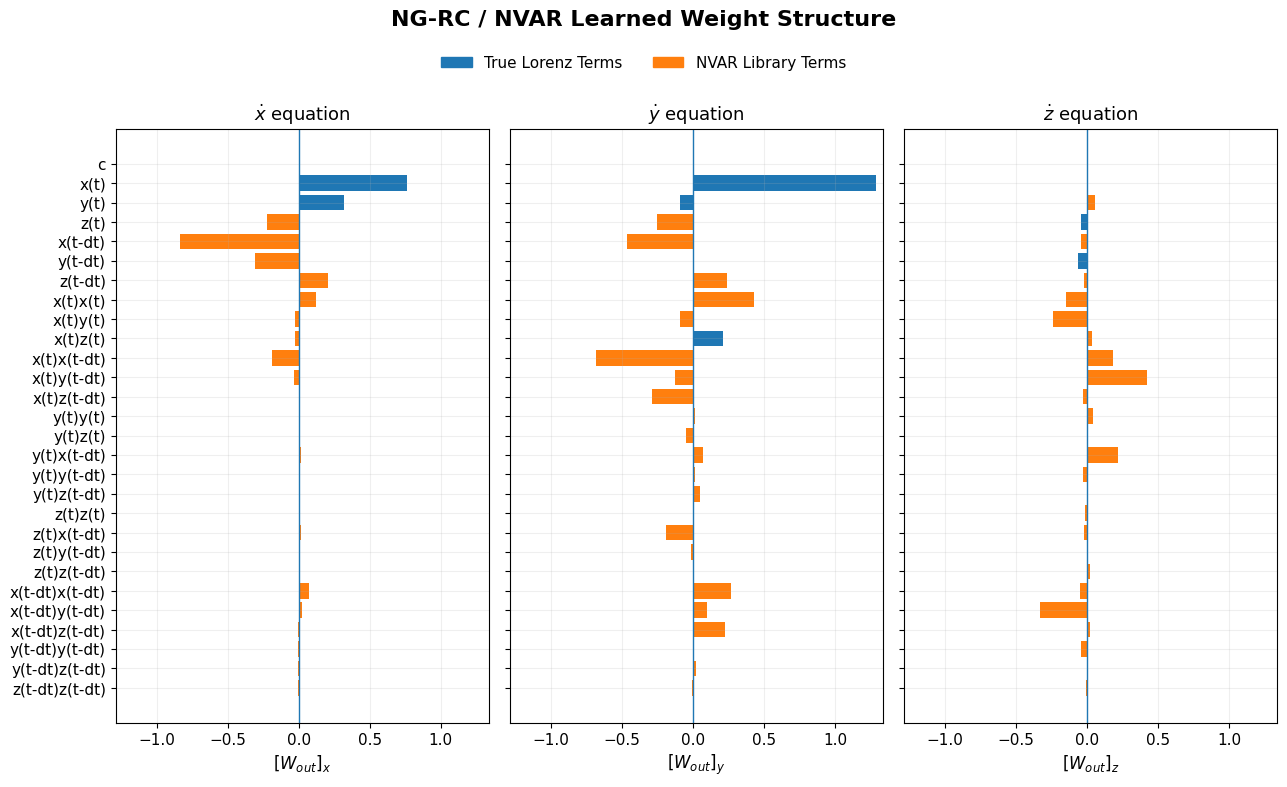

In [22]:
import matplotlib.patches as mpatches

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12
})

fig, axs = plt.subplots(1, 3, figsize=(13, 8), sharey=True)

# X equation
axs[0].barh(y_pos, W_out[0, :], color=colorx)
axs[0].set_yticks(y_pos)
axs[0].set_yticklabels(labels)
axs[0].set_xlabel(r'$[W_{out}]_x$')
axs[0].set_title(r'$\dot{x}$ equation')
axs[0].axvline(0, linewidth=1)
axs[0].grid(alpha=0.2)

# Y equation
axs[1].barh(y_pos, W_out[1, :], color=colory)
axs[1].set_xlabel(r'$[W_{out}]_y$')
axs[1].set_title(r'$\dot{y}$ equation')
axs[1].axvline(0, linewidth=1)
axs[1].grid(alpha=0.2)

# Z equation
axs[2].barh(y_pos, W_out[2, :], color=colorz)
axs[2].set_xlabel(r'$[W_{out}]_z$')
axs[2].set_title(r'$\dot{z}$ equation')
axs[2].axvline(0, linewidth=1)
axs[2].grid(alpha=0.2)

axs[0].invert_yaxis()

# Legend
true_patch = mpatches.Patch(color='tab:blue', label='True Lorenz Terms')
nvar_patch = mpatches.Patch(color='tab:orange', label='NVAR Library Terms')

fig.legend(handles=[true_patch, nvar_patch],
           loc='upper center',
           bbox_to_anchor=(0.5, 0.94),
           ncol=2,
           frameon=False)

fig.suptitle('NG-RC / NVAR Learned Weight Structure',
             fontsize=16,
             fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])

# Symmetric x-axis limits
max_val = np.max(np.abs(W_out))
for ax in axs:
    ax.set_xlim(-max_val, max_val + 0.05)

plt.show()


In [23]:
'''
%matplotlib notebook

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 200

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Time settings
frames = plottime_pts
trail = 100

# Physical time window
t_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]

# Error computation
dist = np.sqrt(
    np.sum(
        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
         - x_test[0:3, :plottime_pts])**2,
        axis=0
    )
)

# Lyapunov time marker
dt = t_eval[1] - t_eval[0]
t_boundary = t_eval[warmtrain_pts-1]
t_lyap = t_boundary + lyaptime_pts * dt

# Create figure
fig = plt.figure(figsize=(13,6))
fig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)

# 3D Lorenz trajectories
ax3d = fig.add_subplot(121, projection='3d')

ax3d.set_xlim(np.min(x[0]), np.max(x[0]))
ax3d.set_ylim(np.min(x[1]), np.max(x[1]))
ax3d.set_zlim(np.min(x[2]), np.max(x[2]))


true_line, = ax3d.plot([], [], [], color='tab:blue', lw=2)
true_point, = ax3d.plot([], [], [], 'o', color='tab:blue')

pred_line, = ax3d.plot([], [], [], color='tab:orange', lw=2, linestyle='--')
pred_point, = ax3d.plot([], [], [], 'o', color='tab:orange')

ax3d.legend([true_line, pred_line],
            ["Ground Truth", "Prediction"],
            loc="upper left",
            bbox_to_anchor=(0.0, 1.02))


# Prediction error plot
ax_err = fig.add_subplot(122)

ax_err.set_xlim(t_error[0], t_error[-1])
ax_err.set_ylim(0, np.max(dist)*1.1)

ax_err.set_title("Prediction Error")
ax_err.set_xlabel("Time")
ax_err.set_ylabel("Euclidean Distance")
ax_err.grid(alpha=0.3)

ax_err.axvline(t_lyap, linestyle=':', color='tab:green', linewidth=1.2)
err_line, = ax_err.plot([], [], color='tab:red', lw=2, alpha=0.8)


# Initialize animation
def init():
    true_line.set_data([], [])
    true_line.set_3d_properties([])
    pred_line.set_data([], [])
    pred_line.set_3d_properties([])
    err_line.set_data([], [])
    return true_line, pred_line, true_point, pred_point, err_line

# Update animation
def update(frame):

    start = max(0, frame - trail)

    # Actual trajectory
    true_line.set_data(
        x[0, warmtrain_pts-1+start:warmtrain_pts-1+frame],
        x[1, warmtrain_pts-1+start:warmtrain_pts-1+frame]
    )
    true_line.set_3d_properties(
        x[2, warmtrain_pts-1+start:warmtrain_pts-1+frame]
    )

    true_point.set_data(
        [x[0, warmtrain_pts-1+frame]],
        [x[1, warmtrain_pts-1+frame]]
    )
    true_point.set_3d_properties(
        [x[2, warmtrain_pts-1+frame]]
    )

    # Predicted trajectory
    pred_line.set_data(
        x_test[0, start:frame],
        x_test[1, start:frame]
    )
    pred_line.set_3d_properties(
        x_test[2, start:frame]
    )

    pred_point.set_data(
        [x_test[0, frame]],
        [x_test[1, frame]]
    )
    pred_point.set_3d_properties(
        [x_test[2, frame]]
    )

    # Error evolution
    err_line.set_data(t_error[:frame], dist[:frame])
    

    return true_line, pred_line, true_point, pred_point, err_line

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=frames,
    init_func=init,
    interval=30,
    blit=False
)

HTML(ani.to_jshtml())

''' 

'\n%matplotlib notebook\n\nimport matplotlib as mpl\nmpl.rcParams[\'animation.embed_limit\'] = 200\n\nfrom matplotlib.animation import FuncAnimation\nfrom IPython.display import HTML\n\n# Time settings\nframes = plottime_pts\ntrail = 100\n\n# Physical time window\nt_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]\n\n# Error computation\ndist = np.sqrt(\n    np.sum(\n        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]\n         - x_test[0:3, :plottime_pts])**2,\n        axis=0\n    )\n)\n\n# Lyapunov time marker\ndt = t_eval[1] - t_eval[0]\nt_boundary = t_eval[warmtrain_pts-1]\nt_lyap = t_boundary + lyaptime_pts * dt\n\n# Create figure\nfig = plt.figure(figsize=(13,6))\nfig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)\n\n# 3D Lorenz trajectories\nax3d = fig.add_subplot(121, projection=\'3d\')\n\nax3d.set_xlim(np.min(x[0]), np.max(x[0]))\nax3d.set_ylim(np.min(x[1]), np.max(x[1]))\nax3d.set_zlim(np.min(x[2]), np.max(x[2]))\n\n\ntrue_line, = ax3d.plot(

In [24]:
'''
%matplotlib notebook

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 200

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Time settings
frames = plottime_pts
trail = 100

# Physical time window
t_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]

# Error computation
dist = np.sqrt(
    np.sum(
        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
         - x_test[0:3, :plottime_pts])**2,
        axis=0
    )
)

# Lyapunov time marker
dt = t_eval[1] - t_eval[0]
t_boundary = t_eval[warmtrain_pts-1]
t_lyap = t_boundary + lyaptime_pts * dt

# Create figure
fig = plt.figure(figsize=(13,6))
fig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)

# 2D Lorenz phase portrait (x vs z)
ax_phase = fig.add_subplot(121)

ax_phase.set_xlim(np.min(x[0]*1.1), np.max(x[0]*1.1))
ax_phase.set_ylim(np.min(x[2]*1.2), np.max(x[2]*1.1))

ax_phase.set_xlabel("x")
ax_phase.set_ylabel("z")
ax_phase.set_title("Phase Portrait (x vs z)")
ax_phase.grid(alpha=0.3)

true_line, = ax_phase.plot([], [], color='tab:blue', lw=2)
true_point, = ax_phase.plot(
    [], [], 'o',
    markerfacecolor='tab:blue',
    markeredgecolor='tab:blue'
)


pred_line, = ax_phase.plot([], [], color='tab:orange', lw=2, linestyle='--')
pred_point, = ax_phase.plot(
    [], [], 'o',
    markerfacecolor='tab:orange',
    markeredgecolor='tab:orange'
)

ax_phase.legend(
    handles=[true_line, pred_line],
    labels=["Ground Truth", "Prediction"],
    loc="upper left"
)


# Prediction error plot
ax_err = fig.add_subplot(122)

ax_err.set_xlim(t_error[0], t_error[-1])
ax_err.set_ylim(0, np.max(dist)*1.1)

ax_err.set_title("Prediction Error")
ax_err.set_xlabel("Time")
ax_err.set_ylabel("Euclidean Distance")
ax_err.grid(alpha=0.3)

ax_err.axvline(t_lyap, linestyle=':', color='tab:green', linewidth=1.2)
err_line, = ax_err.plot([], [], color='tab:red', lw=2, alpha=0.8)

# Initialize animation
def init():
    true_line.set_data([], [])
    pred_line.set_data([], [])
    err_line.set_data([], [])
    return true_line, pred_line, true_point, pred_point, err_line

# Update animation
def update(frame):

    start = max(0, frame - trail)

    # Actual trajectory
    true_line.set_data(
        x[0, warmtrain_pts-1+start:warmtrain_pts-1+frame],
        x[2, warmtrain_pts-1+start:warmtrain_pts-1+frame]
    )

    true_point.set_data(
        [x[0, warmtrain_pts-1+frame]],
        [x[2, warmtrain_pts-1+frame]]
    )

    # Predicted trajectory
    pred_line.set_data(
        x_test[0, start:frame],
        x_test[2, start:frame]
    )

    pred_point.set_data(
        [x_test[0, frame]],
        [x_test[2, frame]]
    )

    # Error evolution
    err_line.set_data(t_error[:frame], dist[:frame])

    return true_line, pred_line, true_point, pred_point, err_line

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=frames,
    init_func=init,
    interval=30,
    blit=False
)

HTML(ani.to_jshtml())
'''

'\n%matplotlib notebook\n\nimport matplotlib as mpl\nmpl.rcParams[\'animation.embed_limit\'] = 200\n\nfrom matplotlib.animation import FuncAnimation\nfrom IPython.display import HTML\n\n# Time settings\nframes = plottime_pts\ntrail = 100\n\n# Physical time window\nt_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]\n\n# Error computation\ndist = np.sqrt(\n    np.sum(\n        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]\n         - x_test[0:3, :plottime_pts])**2,\n        axis=0\n    )\n)\n\n# Lyapunov time marker\ndt = t_eval[1] - t_eval[0]\nt_boundary = t_eval[warmtrain_pts-1]\nt_lyap = t_boundary + lyaptime_pts * dt\n\n# Create figure\nfig = plt.figure(figsize=(13,6))\nfig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)\n\n# 2D Lorenz phase portrait (x vs z)\nax_phase = fig.add_subplot(121)\n\nax_phase.set_xlim(np.min(x[0]*1.1), np.max(x[0]*1.1))\nax_phase.set_ylim(np.min(x[2]*1.2), np.max(x[2]*1.1))\n\nax_phase.set_xlabel("x")\nax_phase.set_ylabel("z

In [25]:
plt.close('all')
%matplotlib inline

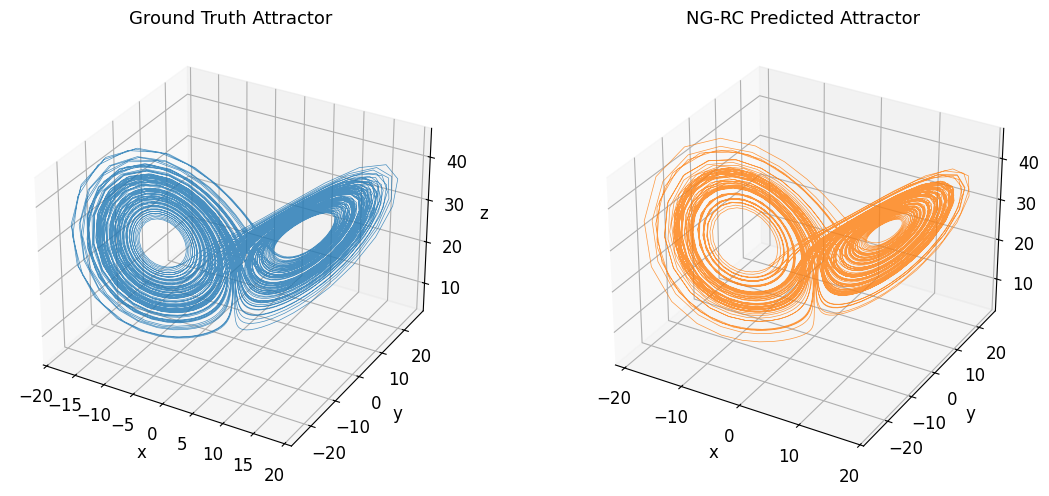

In [26]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12, 5))

# Ground truth attractor (BLACK)
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(
    x[0, warmtrain_pts:maxtime_pts],
    x[1, warmtrain_pts:maxtime_pts],
    x[2, warmtrain_pts:maxtime_pts],
    linewidth=0.5,
    color='tab:blue',
    alpha=0.8
)

ax1.set_title('Ground Truth Attractor')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# NG-RC predicted attractor (RED)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(
    x_test[0, :],
    x_test[1, :],
    x_test[2, :],
    linewidth=0.5,
    color='tab:orange',
    alpha=0.8
)
ax2.set_title('NG-RC Predicted Attractor')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.tight_layout()
plt.show()


### Reference

Gauthier, D. J., Bollt, E., Griffith, A., & Barbosa, W. A. S.  
*Next Generation Reservoir Computing*  

Original code repository:  
https://github.com/quantinfo/ng-rc-paper-code
